### EDA: step by step

- Enviroment Setting (anomaly_eda)
- ToyCar Overview
  - ToyCar Train
  - ToyCar Train + Test

In [1]:
!pip install librosa matplotlib seaborn pandas scikit-learn

In [2]:
toycar_dir = "../../datasets/dev/"
classes = ["ToyCar" , "ToyTrain", "bearing", "fan", "gearbox", "slider", "valve"]

# /home/uturtle/datasets/data_eda/unziped/dev/ToyCar/attributes_00.csv
# first attribute - file_name (no domain, label, all train data normal data)
# Task: Eject wav file and convert them linear spectogram.
#   1. we First EDA ToyCar
#       1. Eject ToyCar wav files 
#       2. Convert linear spectogram
#       3. Make Distribution spectogram
#       4. Dimension Decrease (PCA...)

In [3]:
import pandas as pd
import os

# ToyCar 데이터셋 경로 설정
toycar_dir = "../../datasets/dev/ToyCar"
attributes_file = os.path.join(toycar_dir, "attributes_00.csv")

# CSV 파일 읽기
df = pd.read_csv(attributes_file)

# 열 이름 출력
print("CSV 파일의 열 이름:", df.columns.tolist())


CSV 파일의 열 이름: ['file_name', 'd1p', 'd1v', 'd2p', 'd2v', 'd3p', 'd3v']


### only train data. All label: normal data

Loaded 1000 ToyCar audio files.
Unique Sample Rates: {16000}
Unique Audio Lengths (samples): {192000}


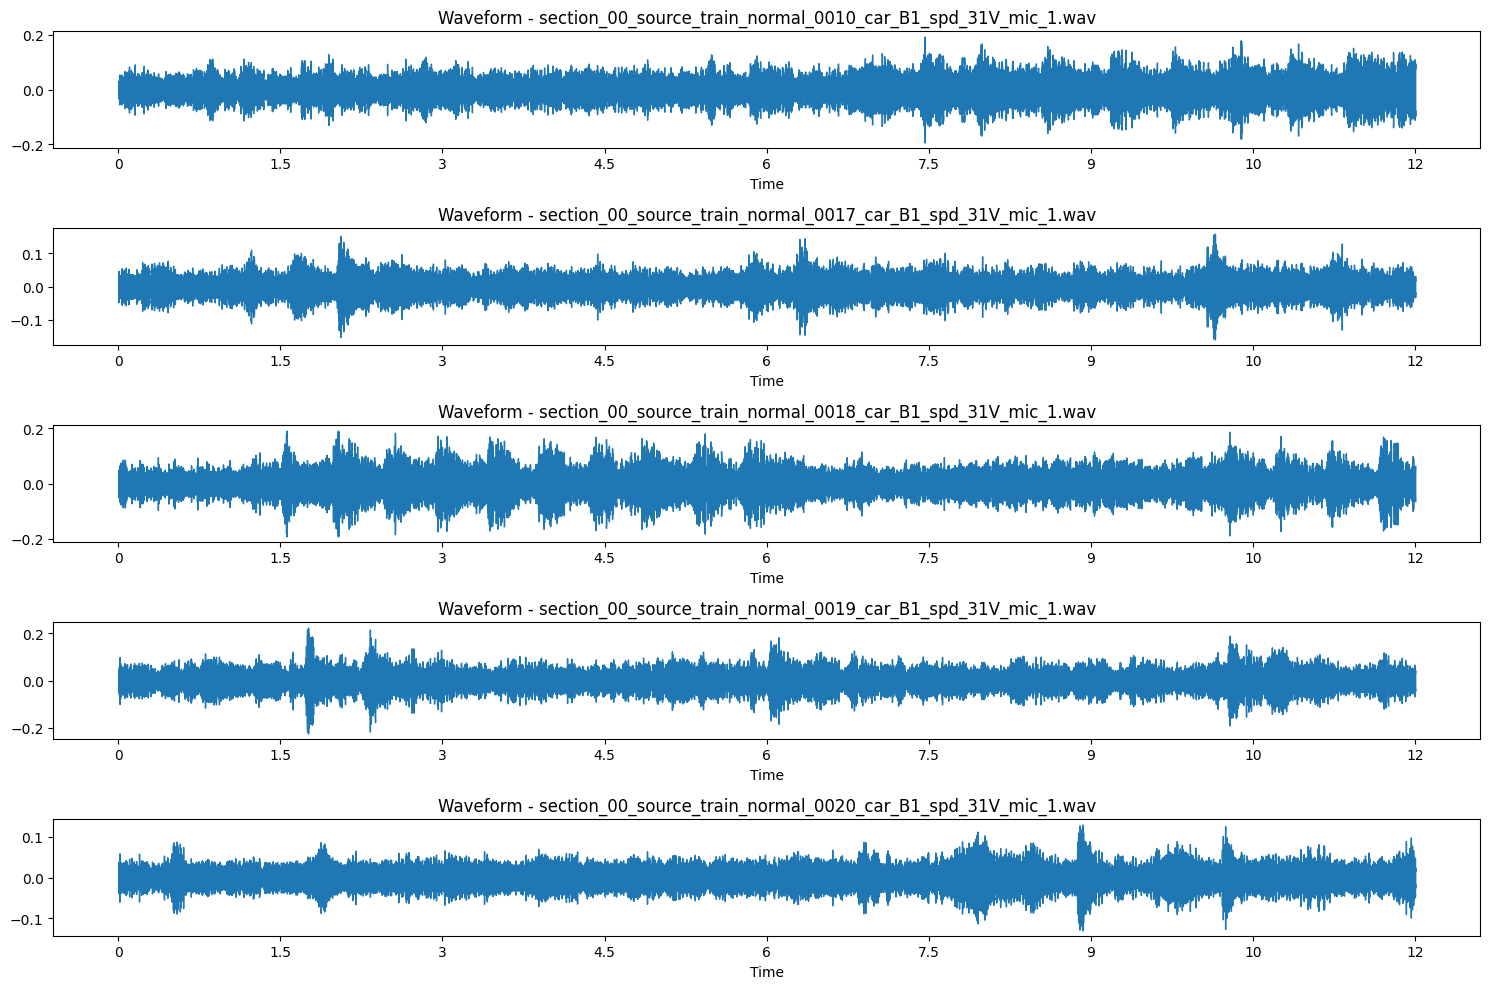

Converted 1000 wav files to linear spectrograms.


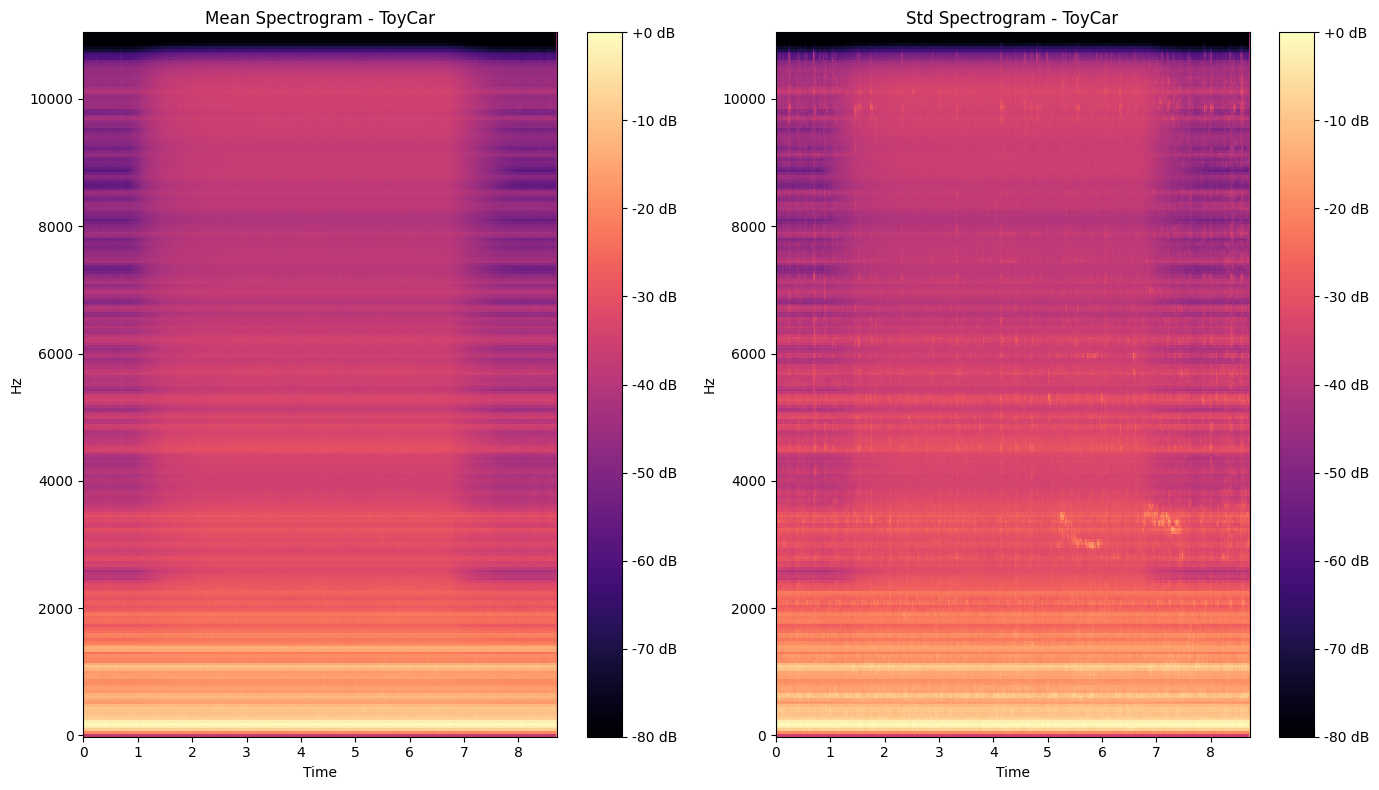

Applied PCA to spectrograms.


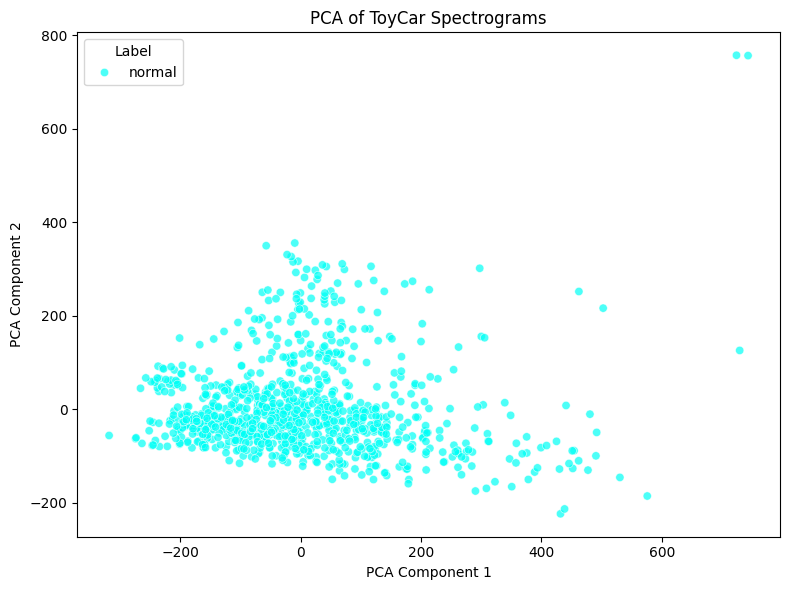

Extracted additional audio features from 1000 files.


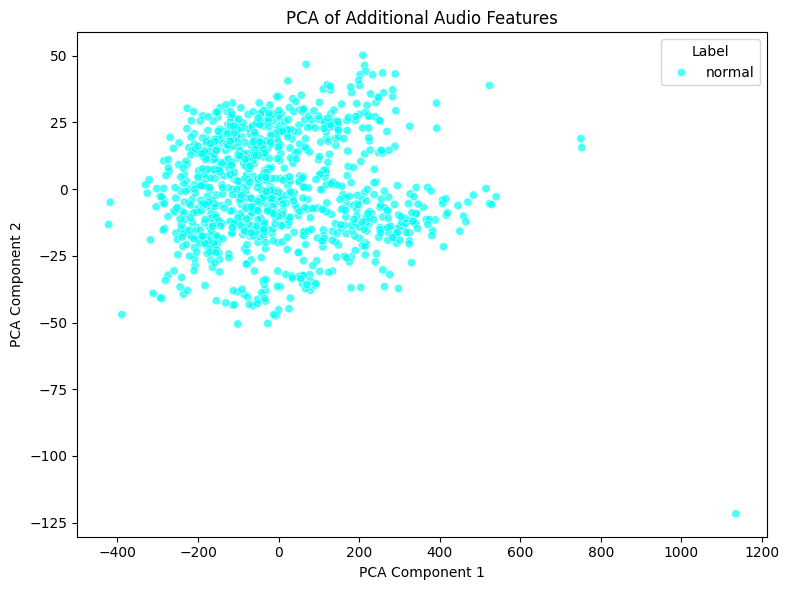

In [4]:
import os
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# 데이터셋 경로 및 카테고리 설정
datasets = "../../datasets/dev"
classes = ["ToyCar", "ToyTrain", "bearing", "fan", "gearbox", "slider", "valve"]

# ToyCar 데이터셋 경로 설정
toycar_dir = os.path.join(datasets, "ToyCar")
attributes_file = os.path.join(toycar_dir, "attributes_00.csv")

# Step 1: ToyCar wav 파일 및 메타데이터 추출
def load_toycar_data(toycar_dir, attributes_file):
    # attributes_00.csv 파일 읽기
    df = pd.read_csv(attributes_file)
    
    filenames = df['file_name'].tolist()
    filenames = [name for name in filenames if 'test' not in name]
    
    # 모든 데이터를 정상으로 간주 (레이블 없음)
    [os.path.join(datasets, f) for f in filenames]
    labels = ['normal'] * len(filenames)
    
    # 전체 파일 경로 생성
    file_paths = [os.path.join(datasets, f) for f in filenames]
    
    return file_paths, labels

# Step 2: wav 파일을 선형 스펙트로그램으로 변환
def wav_to_linear_spectrogram(file_paths, n_fft=512, hop_length=256, window='hann'):
    spectrograms = []
    for path in file_paths:
        if not os.path.isfile(path):
            print(f"파일이 존재하지 않습니다: {path}")
            continue
        try:
            y, sr = librosa.load(path, sr=None)
            # STFT 계산
            S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window)
            # 크기 스펙트로그램 계산
            S_mag = np.abs(S)
            spectrograms.append(S_mag)
        except Exception as e:
            print(f"오디오 파일 로드 중 오류 발생: {path}, 오류: {e}")
    return spectrograms

# Step 3: 스펙트로그램 분포 시각화
def plot_spectrogram_distribution(spectrograms, title="Spectrogram Distribution"):
    if not spectrograms:
        print("스펙트로그램 데이터가 없습니다.")
        return
    
    # 모든 스펙트로그램을 스택하여 3D 배열로 만듦 (num_samples, freq_bins, time_frames)
    S_stack = np.stack(spectrograms, axis=0)
    
    # 평균 및 표준편차 계산
    S_mean = np.mean(S_stack, axis=0)
    S_std = np.std(S_stack, axis=0)

    plt.figure(figsize=(14, 8))

    # 평균 스펙트로그램 시각화
    plt.subplot(1, 2, 1)
    librosa.display.specshow(librosa.amplitude_to_db(S_mean, ref=np.max), 
                             sr=22050, hop_length=256, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mean Spectrogram - {title}')

    # 표준편차 스펙트로그램 시각화
    plt.subplot(1, 2, 2)
    librosa.display.specshow(librosa.amplitude_to_db(S_std, ref=np.max), 
                             sr=22050, hop_length=256, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Std Spectrogram - {title}')

    plt.tight_layout()
    plt.show()

# Step 4: 차원 축소(PCA) 적용
def apply_pca(spectrograms, n_components=2):
    # 스펙트로그램을 평탄화 (num_samples, freq_bins * time_frames)
    flattened_spectrograms = [s.flatten() for s in spectrograms]
    X = np.array(flattened_spectrograms)
    
    # 스케일링: 각 특징을 평균 0, 분산 1로 스케일링
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    
    # PCA 적용
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    return X_pca, pca

# PCA 결과 시각화
def plot_pca(X_pca, labels, title="PCA of Spectrograms"):
    plt.figure(figsize=(8,6))
    unique_labels = list(set(labels))
    palette = sns.color_palette("hsv", len(unique_labels))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette=palette, alpha=0.7)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Label')
    plt.tight_layout()
    plt.show()

# Step 5: 오디오 특징 추출 및 추가 시각화 (옵션)
def extract_audio_features(file_paths):
    features = []
    for path in file_paths:
        if not os.path.isfile(path):
            print(f"파일이 존재하지 않습니다: {path}")
            continue
        try:
            y, sr = librosa.load(path, sr=None)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
            zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
            # 특징 결합 (평균 값 사용)
            feature = np.concatenate([
                np.mean(mfcc, axis=1),
                np.mean(spectral_centroid, axis=1),
                np.mean(zero_crossing_rate, axis=1)
            ])
            features.append(feature)
        except Exception as e:
            print(f"오디오 파일 로드 중 오류 발생: {path}, 오류: {e}")
    return np.array(features)

# 오디오 특징 시각화
def plot_audio_features_pca(features, labels, title="PCA of Audio Features"):
    if features.size == 0:
        print("오디오 특징 데이터가 없습니다.")
        return
    # PCA 적용
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(features)
    
    # 시각화
    plt.figure(figsize=(8,6))
    unique_labels = list(set(labels))
    palette = sns.color_palette("hsv", len(unique_labels))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette=palette, alpha=0.7)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Label')
    plt.tight_layout()
    plt.show()

# Step 6: 데이터 품질 및 일관성 확인
def check_audio_consistency(file_paths):
    sample_rates = []
    lengths = []
    for path in file_paths:
        if not os.path.isfile(path):
            print(f"파일이 존재하지 않습니다: {path}")
            continue
        try:
            y, sr = librosa.load(path, sr=None)
            sample_rates.append(sr)
            lengths.append(len(y))
        except Exception as e:
            print(f"오디오 파일 로드 중 오류 발생: {path}, 오류: {e}")
    
    sr_unique = set(sample_rates)
    length_unique = set(lengths)
    
    print(f"Unique Sample Rates: {sr_unique}")
    print(f"Unique Audio Lengths (samples): {length_unique}")

# Step 7: 파형 시각화 (임의의 샘플)
def plot_waveforms(file_paths, sample_size=5):
    plt.figure(figsize=(15, 10))
    for i, path in enumerate(file_paths[:sample_size]):
        if not os.path.isfile(path):
            print(f"파일이 존재하지 않습니다: {path}")
            continue
        try:
            y, sr = librosa.load(path, sr=None)
            plt.subplot(sample_size, 1, i+1)
            librosa.display.waveshow(y, sr=sr)
            plt.title(f'Waveform - {os.path.basename(path)}')
        except Exception as e:
            print(f"오디오 파일 로드 중 오류 발생: {path}, 오류: {e}")
    plt.tight_layout()
    plt.show()


# Step 1: 데이터 로드
file_paths, labels = load_toycar_data(toycar_dir, attributes_file)
print(f"Loaded {len(file_paths)} ToyCar audio files.")

# Step 6: 데이터 품질 및 일관성 확인
check_audio_consistency(file_paths)

# Step 7: 샘플 파형 시각화
plot_waveforms(file_paths, sample_size=5)

# Step 2: 선형 스펙트로그램 변환
spectrograms = wav_to_linear_spectrogram(file_paths)
print(f"Converted {len(spectrograms)} wav files to linear spectrograms.")

# Step 3: 스펙트로그램 분포 시각화
plot_spectrogram_distribution(spectrograms, title="ToyCar")

# Step 4: PCA 적용
X_pca, pca_model = apply_pca(spectrograms, n_components=2)
print("Applied PCA to spectrograms.")

# Step 4: PCA 결과 시각화
plot_pca(X_pca, labels, title="PCA of ToyCar Spectrograms")

# Step 5: 추가 오디오 특징 추출 및 PCA 시각화
audio_features = extract_audio_features(file_paths)
print(f"Extracted additional audio features from {len(audio_features)} files.")

# 오디오 특징 PCA 시각화
plot_audio_features_pca(audio_features, labels, title="PCA of Additional Audio Features")



# Train + Test (with Anomaly)

Loaded 1200 ToyCar audio files.
Unique Sample Rates: {16000}
Unique Audio Lengths (samples): {192000}


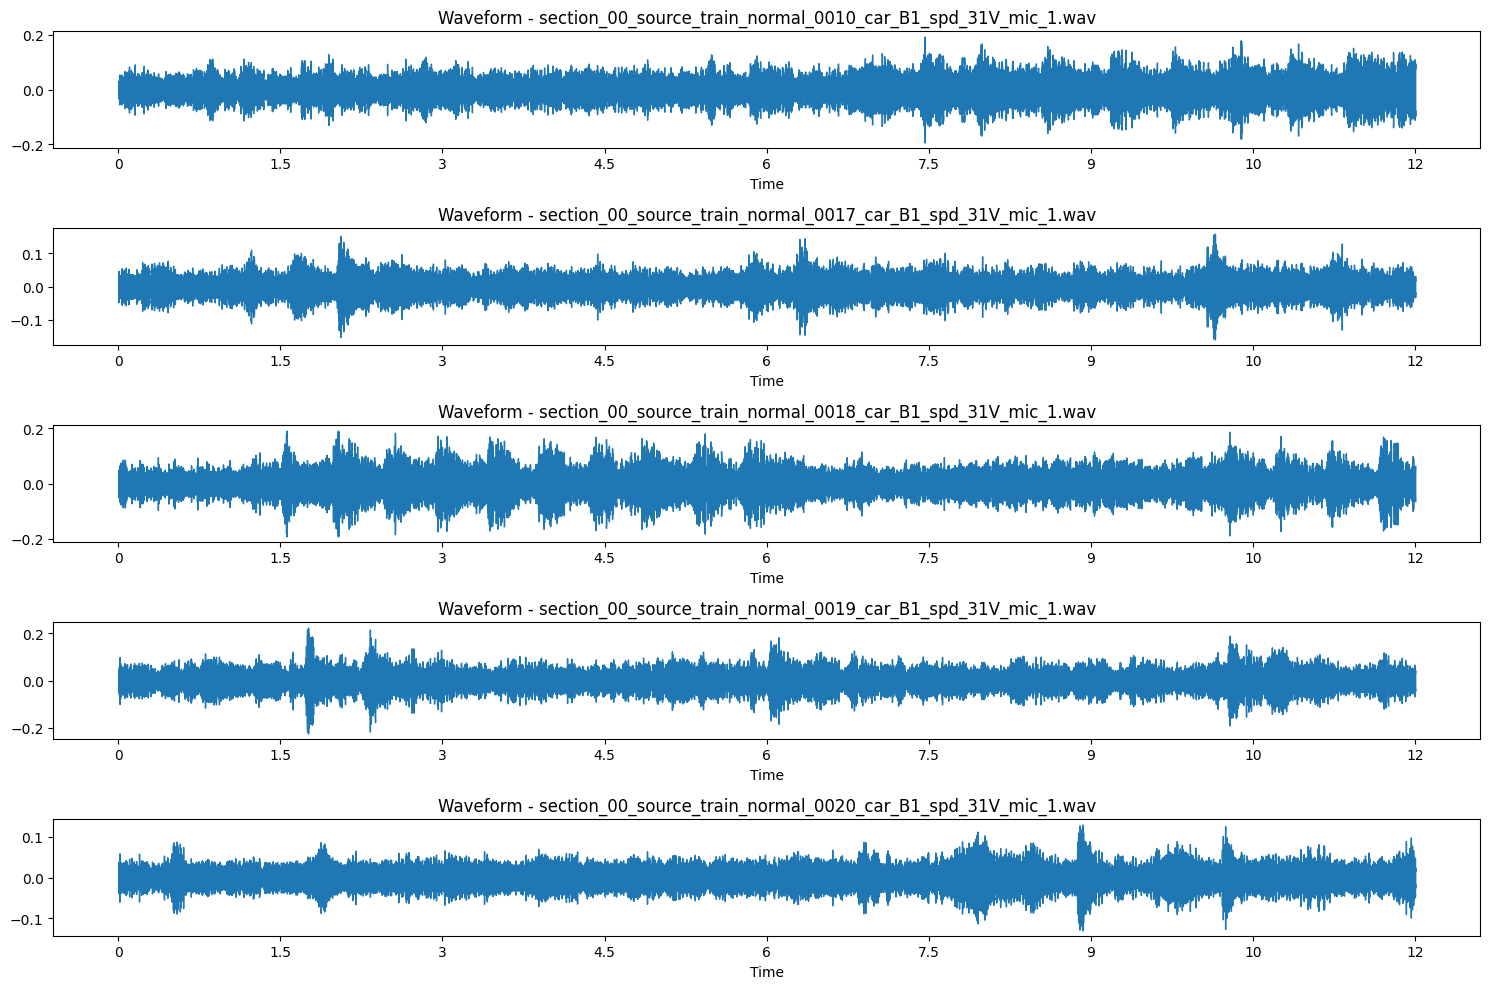

Converted 1200 wav files to linear spectrograms.


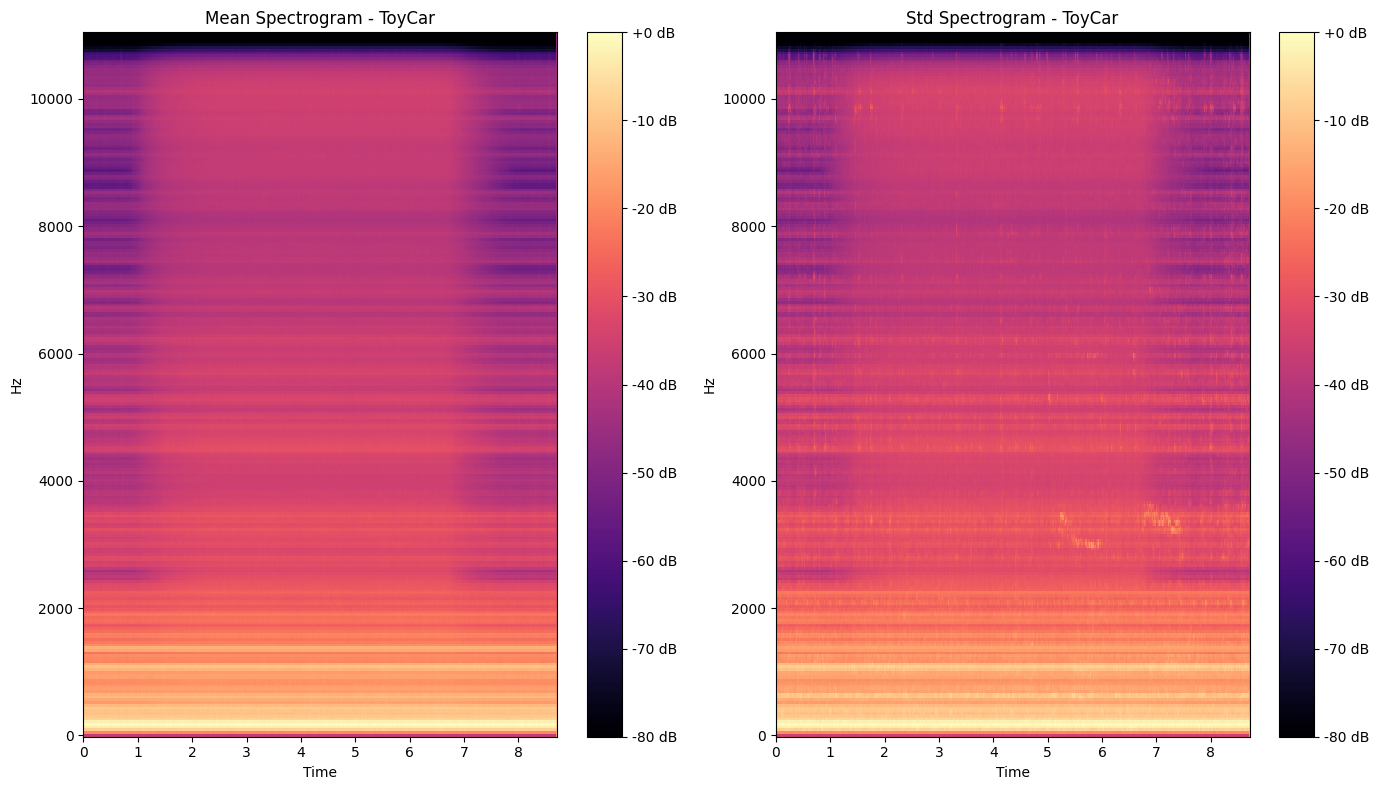

Applied PCA to spectrograms.


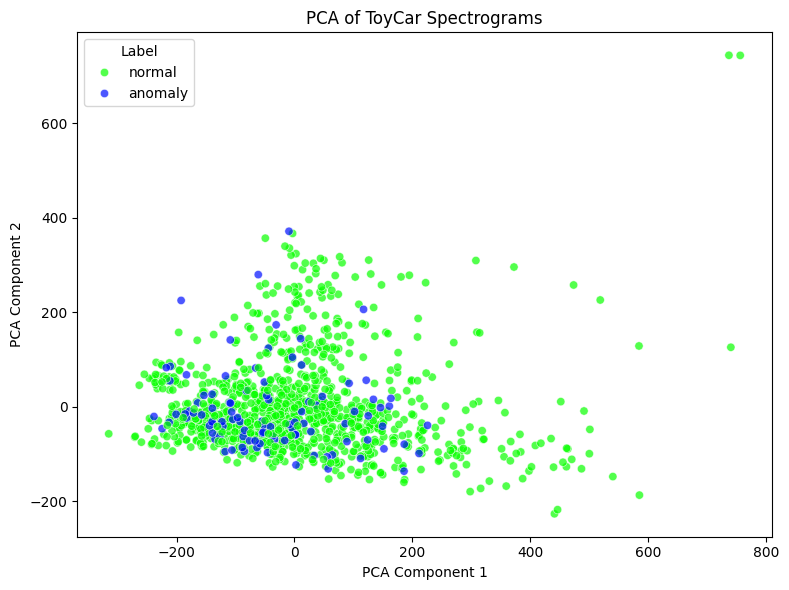

Extracted additional audio features from 1200 files.


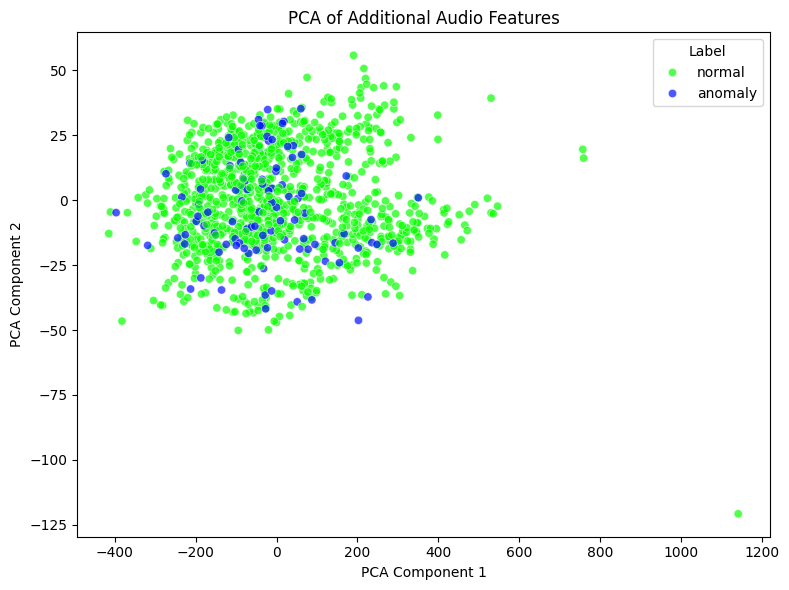

In [5]:
import os
import pandas as pd
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# 데이터셋 경로 및 카테고리 설정
datasets = "../../datasets/dev"
classes = ["ToyCar", "ToyTrain", "bearing", "fan", "gearbox", "slider", "valve"]

# ToyCar 데이터셋 경로 설정
toycar_dir = os.path.join(datasets, "ToyCar")
attributes_file = os.path.join(toycar_dir, "attributes_00.csv")

# Step 1: ToyCar wav 파일 및 메타데이터 추출
def load_toycar_data(toycar_dir, attributes_file):
    # attributes_00.csv 파일 읽기
    df = pd.read_csv(attributes_file)
    
    filenames = df['file_name'].tolist()
    labels = ['anomaly' if 'anomaly' in name else 'normal' for name in filenames]
    
    # 전체 파일 경로 생성
    file_paths = [os.path.join(datasets, f) for f in filenames]
    
    return file_paths, labels

# Step 2: wav 파일을 선형 스펙트로그램으로 변환
def wav_to_linear_spectrogram(file_paths, n_fft=512, hop_length=256, window='hann'):
    spectrograms = []
    for path in file_paths:
        if not os.path.isfile(path):
            print(f"파일이 존재하지 않습니다: {path}")
            continue
        try:
            y, sr = librosa.load(path, sr=None)
            # STFT 계산
            S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window)
            # 크기 스펙트로그램 계산
            S_mag = np.abs(S)
            spectrograms.append(S_mag)
        except Exception as e:
            print(f"오디오 파일 로드 중 오류 발생: {path}, 오류: {e}")
    return spectrograms

# Step 3: 스펙트로그램 분포 시각화
def plot_spectrogram_distribution(spectrograms, title="Spectrogram Distribution"):
    if not spectrograms:
        print("스펙트로그램 데이터가 없습니다.")
        return
    
    # 모든 스펙트로그램을 스택하여 3D 배열로 만듦 (num_samples, freq_bins, time_frames)
    S_stack = np.stack(spectrograms, axis=0)
    
    # 평균 및 표준편차 계산
    S_mean = np.mean(S_stack, axis=0)
    S_std = np.std(S_stack, axis=0)

    plt.figure(figsize=(14, 8))

    # 평균 스펙트로그램 시각화
    plt.subplot(1, 2, 1)
    librosa.display.specshow(librosa.amplitude_to_db(S_mean, ref=np.max), 
                             sr=22050, hop_length=256, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mean Spectrogram - {title}')

    # 표준편차 스펙트로그램 시각화
    plt.subplot(1, 2, 2)
    librosa.display.specshow(librosa.amplitude_to_db(S_std, ref=np.max), 
                             sr=22050, hop_length=256, x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Std Spectrogram - {title}')

    plt.tight_layout()
    plt.show()

# Step 4: 차원 축소(PCA) 적용
def apply_pca(spectrograms, n_components=2):
    # 스펙트로그램을 평탄화 (num_samples, freq_bins * time_frames)
    flattened_spectrograms = [s.flatten() for s in spectrograms]
    X = np.array(flattened_spectrograms)
    
    # 스케일링: 각 특징을 평균 0, 분산 1로 스케일링
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    
    # PCA 적용
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    return X_pca, pca

# PCA 결과 시각화
def plot_pca(X_pca, labels, title="PCA of Spectrograms"):
    plt.figure(figsize=(8,6))
    unique_labels = list(set(labels))
    palette = sns.color_palette("hsv", len(unique_labels))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette=palette, alpha=0.7)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Label')
    plt.tight_layout()
    plt.show()

# Step 5: 오디오 특징 추출 및 추가 시각화 (옵션)
def extract_audio_features(file_paths):
    features = []
    for path in file_paths:
        if not os.path.isfile(path):
            print(f"파일이 존재하지 않습니다: {path}")
            continue
        try:
            y, sr = librosa.load(path, sr=None)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
            zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
            # 특징 결합 (평균 값 사용)
            feature = np.concatenate([
                np.mean(mfcc, axis=1),
                np.mean(spectral_centroid, axis=1),
                np.mean(zero_crossing_rate, axis=1)
            ])
            features.append(feature)
        except Exception as e:
            print(f"오디오 파일 로드 중 오류 발생: {path}, 오류: {e}")
    return np.array(features)

# 오디오 특징 시각화
def plot_audio_features_pca(features, labels, title="PCA of Audio Features"):
    if features.size == 0:
        print("오디오 특징 데이터가 없습니다.")
        return
    # PCA 적용
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(features)
    
    # 시각화
    plt.figure(figsize=(8,6))
    unique_labels = list(set(labels))
    palette = sns.color_palette("hsv", len(unique_labels))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette=palette, alpha=0.7)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Label')
    plt.tight_layout()
    plt.show()

# Step 6: 데이터 품질 및 일관성 확인
def check_audio_consistency(file_paths):
    sample_rates = []
    lengths = []
    for path in file_paths:
        if not os.path.isfile(path):
            print(f"파일이 존재하지 않습니다: {path}")
            continue
        try:
            y, sr = librosa.load(path, sr=None)
            sample_rates.append(sr)
            lengths.append(len(y))
        except Exception as e:
            print(f"오디오 파일 로드 중 오류 발생: {path}, 오류: {e}")
    
    sr_unique = set(sample_rates)
    length_unique = set(lengths)
    
    print(f"Unique Sample Rates: {sr_unique}")
    print(f"Unique Audio Lengths (samples): {length_unique}")

# Step 7: 파형 시각화 (임의의 샘플)
def plot_waveforms(file_paths, sample_size=5):
    plt.figure(figsize=(15, 10))
    for i, path in enumerate(file_paths[:sample_size]):
        if not os.path.isfile(path):
            print(f"파일이 존재하지 않습니다: {path}")
            continue
        try:
            y, sr = librosa.load(path, sr=None)
            plt.subplot(sample_size, 1, i+1)
            librosa.display.waveshow(y, sr=sr)
            plt.title(f'Waveform - {os.path.basename(path)}')
        except Exception as e:
            print(f"오디오 파일 로드 중 오류 발생: {path}, 오류: {e}")
    plt.tight_layout()
    plt.show()


# Step 1: 데이터 로드
file_paths, labels = load_toycar_data(toycar_dir, attributes_file)
print(f"Loaded {len(file_paths)} ToyCar audio files.")

# Step 6: 데이터 품질 및 일관성 확인
check_audio_consistency(file_paths)

# Step 7: 샘플 파형 시각화
plot_waveforms(file_paths, sample_size=5)

# Step 2: 선형 스펙트로그램 변환
spectrograms = wav_to_linear_spectrogram(file_paths)
print(f"Converted {len(spectrograms)} wav files to linear spectrograms.")

# Step 3: 스펙트로그램 분포 시각화
plot_spectrogram_distribution(spectrograms, title="ToyCar")

# Step 4: PCA 적용
X_pca, pca_model = apply_pca(spectrograms, n_components=2)
print("Applied PCA to spectrograms.")

# Step 4: PCA 결과 시각화
plot_pca(X_pca, labels, title="PCA of ToyCar Spectrograms")

# Step 5: 추가 오디오 특징 추출 및 PCA 시각화
audio_features = extract_audio_features(file_paths)
print(f"Extracted additional audio features from {len(audio_features)} files.")

# 오디오 특징 PCA 시각화
plot_audio_features_pca(audio_features, labels, title="PCA of Additional Audio Features")

